In [8]:
from mysklearn.myclassifiers import MyPyTable, MyKNeighborsClassifier, MyNaiveBayesClassifier
from mysklearn import myutils
import numpy as np
from mysklearn import myevaluation
import importlib
import discretization

All columns prior to cleaning:

"SITE_ID","DATE_TIME","TEMPERATURE","TEMPERATURE_DELTA","RELATIVE_HUMIDITY","SOLAR_RADIATION","OZONE",
"PRECIPITATION","WINDSPEED","WIND_DIRECTION",
"SIGMA_THETA","FLOW_RATE","WINDSPEED_SCALAR","WETNESS","SHELTER_TEMPERATURE","QA_CODE","UPDATE_DATE"

To remove:
* "SITE_ID"
* "TEMPERATURE_DELTA"
* "SIGMA_THETA"
* "QA_CODE"
* "UPDATE_DATE"
* "WETNESS"

In [9]:
table = MyPyTable()
table.load_from_file("meteorological-hourly.csv")
clean_table = table.get_multiple_columns(["DATE_TIME","TEMPERATURE","RELATIVE_HUMIDITY","SOLAR_RADIATION","OZONE",\
    "PRECIPITATION","WINDSPEED","WIND_DIRECTION","FLOW_RATE","WINDSPEED_SCALAR","SHELTER_TEMPERATURE"], "", False)
print(clean_table.get_shape())
clean_table.save_to_file("meteorological-hourly-clean.csv")

(36699, 11)


Ozone Classification:
* Low: 0-15
* Normal: 16-35
* High: 36-

In [10]:
ozone_column = clean_table.get_column("OZONE")
classified_column = []
for ozone in ozone_column:
    classified_column.append(discretization.ozone_assigning(ozone))
clean_table_2 = clean_table.get_multiple_columns(["DATE_TIME","TEMPERATURE","RELATIVE_HUMIDITY","SOLAR_RADIATION",\
    "PRECIPITATION","WINDSPEED","WIND_DIRECTION","FLOW_RATE","WINDSPEED_SCALAR","SHELTER_TEMPERATURE"], "", False)
print(len(clean_table_2.data))
clean_table_2.add_column("OZONE", ozone_column)
clean_table_2.add_column("OZONE_LEVEL", classified_column)

36699


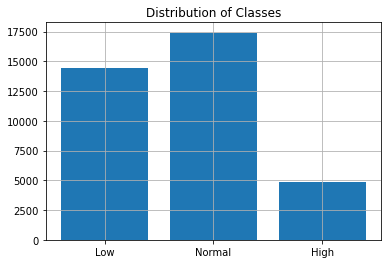

In [11]:
classifiers = ["Low", "Normal", "High"]
classifier_count = myutils.count_unique_items(classified_column, classifiers)
myutils.bar_chart(classifiers, classifier_count, "Distribution of Classes")

In [12]:
importlib.reload(myutils)

date = clean_table.get_column("DATE_TIME")
temp = clean_table.get_column("TEMPERATURE")
humidity = clean_table.get_column("RELATIVE_HUMIDITY")
radiation = clean_table.get_column("SOLAR_RADIATION")
precip = clean_table.get_column("PRECIPITATION")
wind_speed = clean_table.get_column("WINDSPEED")
wind_dir = clean_table.get_column("WIND_DIRECTION")
flow = clean_table.get_column("FLOW_RATE")
wind_scalar = clean_table.get_column("WINDSPEED_SCALAR")
shelter = clean_table.get_column("SHELTER_TEMPERATURE")
X = [[date[i], temp[i], humidity[i], radiation[i], precip[i], wind_speed[i], wind_dir[i], flow[i], wind_scalar[i], shelter[i]] for i in range(len(temp))]
X_to_trim = [X[i] + [classified_column[i]] for i in range(len(X))]
classes, class_subtables = myutils.group_by_for_trimming(X_to_trim, classified_column)
np.random.seed(0)
rows_to_keep = []
for i in range(350):
    to_keep = class_subtables[0].pop(np.random.randint(0, len(class_subtables[0])))
    rows_to_keep.append(to_keep[0])
    to_keep = class_subtables[1].pop(np.random.randint(0, len(class_subtables[1])))
    rows_to_keep.append(to_keep[0])
    to_keep = class_subtables[2].pop(np.random.randint(0, len(class_subtables[2])))
    rows_to_keep.append(to_keep[0])

rows_to_remove = list(np.arange(0, len(clean_table_2.data)))
for row in rows_to_keep:
    rows_to_remove.remove(row)
clean_table_2.drop_rows(rows_to_remove)
clean_table_2.save_to_file("meteorological-hourly-clean.csv")

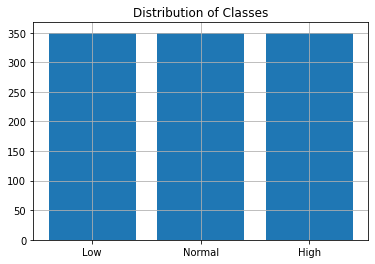

In [13]:
classifier_count2 = myutils.count_unique_items(clean_table_2.get_column("OZONE_LEVEL"), classifiers)
myutils.bar_chart(classifiers, classifier_count2, "Distribution of Classes")